In [ ]:
import os
import sys
import cv2
import numpy as np
import traceback
import xml.etree.ElementTree as ET

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../src/')

# Parse .xml to .txt

In [ ]:
VOC_CLASSES = (    # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct         = {}
        difficult          = int(obj.find('difficult').text)
        if difficult == 1:
            # print(filename)
            continue
        obj_struct['name'] = obj.find('name').text
        bbox               = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text)),
                              int(float(bbox.find('ymax').text))]
        objects.append(obj_struct)

    return objects

def parse_dir(dir_annotations, dir_op):
    file_op = open(dir_op,'w')
    xml_files = os.listdir(dir_annotations)
    for i, xml_file in enumerate(xml_files):
        #if (i % 100 == 0):
        #    print (' - i:', i)
        try:
            results    = parse_rec(os.path.join(dir_annotations,xml_file))
            image_path = xml_file.split('.')[0] + '.jpg'
            if len(results)==0:
                print(' - No useful anno : ', xml_file)
                continue

            file_op.write(image_path)

            for result in results:
                class_name = result['name']
                bbox       = result['bbox']
                class_name = VOC_CLASSES.index(class_name)
                file_op.write(' '+str(bbox[0])+' '+str(bbox[1])+' '+str(bbox[2])+' '+str(bbox[3])+' '+str(class_name))

            file_op.write('\n')
        except Exception:
            traceback.print_exc()
            print (' - Error : File ID',i, ' || Name : ', xml_file)
    
    file_op.close()
        

if __name__ == "__main__":
    if (0):
        dir_annotations = '../../data/VOCdevkit_trainval/VOC2007/Annotations'
        dir_op      = os.path.join(dir_annotations, '../anno_trainval.txt')
        print (dir_op)
    else:
        dir_annotations = '../../data/VOCdevkit_test/VOC2007/Annotations/'
        dir_op      = os.path.join(dir_annotations, '../anno_test.txt')
    
    parse_dir(dir_annotations, dir_op)
    
    

# Create PyTorch DataLoaders

 - Total Images:  5011


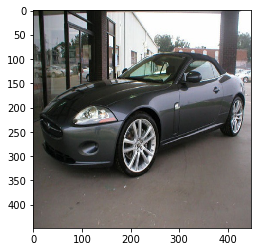

In [9]:
class YoloDataset(data.Dataset):
    
    def __init__(self, dir_data, file_annotations
                 , train
                 , image_size, grid_num
                 , flag_augm
                 , transform):
        
        self.dir_data   = dir_data
        self.dir_img    = os.path.join(dir_data, 'JPEGImages')
        self.train      = train
        self.transform  = transform
        
        self.fnames     = []
        self.boxes      = []
        self.labels     = []
        self.mean       = (123,117,104) # RGB ([How?])
        
        self.grid_num   = grid_num
        self.image_size = image_size
        self.flag_augm  = flag_augm

        with open(file_annotations) as f:
            for line in f.readlines():
                splited   = line.strip().split()
                self.fnames.append(splited[0])
                num_boxes = (len(splited) - 1) // 5
                box       = []
                label     = []
                for i in range(num_boxes):
                    x  = float(splited[1+5*i])
                    y  = float(splited[2+5*i])
                    x2 = float(splited[3+5*i])
                    y2 = float(splited[4+5*i])
                    c  = splited[5+5*i]
                    box.append([x,y,x2,y2])
                    label.append(int(c)+1)
                self.boxes.append(torch.Tensor(box))
                self.labels.append(torch.LongTensor(label))
                
        self.num_samples = len(self.boxes)
    
    def __getitem__(self,idx, verbose=0):
        fname  = self.fnames[idx]
        img    = cv2.imread(os.path.join(self.dir_img, fname), cv2.IMREAD_UNCHANGED)
        boxes  = self.boxes[idx].clone()
        labels = self.labels[idx].clone()
        
        if (0):
            print (' - fname :', fname)
            print (' - path : ', os.path.join(self.dir_img, fname))
            # plt.imshow(img)
            print (' - labels : ', labels)
        
        if self.train:
            if (self.flag_augm == 1):
                if (0):
                    img = self.random_bright(img)
                img, boxes       = self.random_flip(img, boxes)
                img,boxes        = self.randomScale(img,boxes)
                img              = self.randomBlur(img)
                img              = self.RandomBrightness(img)
                img              = self.RandomHue(img)
                img              = self.RandomSaturation(img)
                img,boxes,labels = self.randomShift(img,boxes,labels)
                img,boxes,labels = self.randomCrop(img,boxes,labels)

        h,w,_  = img.shape
        
        boxes  /= torch.Tensor([w,h,w,h]).expand_as(boxes)
        img    = self.BGR2RGB(img) #because pytorch pretrained model use RGB
        #img    = self.subMean(img,self.mean) 
        img    = cv2.resize(img,(self.image_size,self.image_size))
        target = self.encoder(boxes,labels) # 7x7x30
        for t in self.transform:
            img = t(img)
        return img,target
    
    def __len__(self):
        return self.num_samples
    
    def encoder(self,boxes,labels):
        '''
        boxes (tensor) [[x1,y1,x2,y2],[]]
        labels (tensor) [...]
        return 7x7x30
        '''
        
        target    = torch.zeros((self.grid_num, self.grid_num,30))
        cell_size = 1./self.grid_num
        wh        = boxes[:,2:] - boxes[:,:2]
        cxcy      = (boxes[:,2:] + boxes[:,:2])/2
        for i in range(cxcy.size()[0]):
            cxcy_sample                       = cxcy[i]
            ij                                = (cxcy_sample/cell_size).ceil()-1 #
            target[int(ij[1]),int(ij[0]),4]   = 1
            target[int(ij[1]),int(ij[0]),9]   = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            xy                                = ij*cell_size # The relative coordinates of the upper left corner of the matched mesh
            delta_xy                          = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2]  = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
            
        return target
    
    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    def BGR2HSV(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    def HSV2BGR(self,img):
        return cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    
    def subMean(self,bgr,mean):
        mean = np.array(mean, dtype=np.float32)
        bgr  = bgr - mean
        return bgr
    
    def display(self, X):
        plt.imshow(X.data.numpy().transpose(1,2,0))
    
    

if __name__ == "__main__":
    dir_annotations  = '../../data/VOCdevkit_trainval/VOC2007'
    file_annotations = '../../data/VOCdevkit_trainval/VOC2007/anno_trainval.txt'
    image_size       = 448
    grid_num         = 14
    flag_augm        = 0
    train            = True
    
    YoloDatasetTrain = YoloDataset(dir_annotations, file_annotations
                                , train
                                , image_size, grid_num
                                , flag_augm
                                , transform = [transforms.ToTensor()] )
    
    print (' - Total Images: ', len(YoloDatasetTrain))
    if (1):
        idx = np.random.randint(len(YoloDatasetTrain))
        X,Y = YoloDatasetTrain[idx]
        YoloDatasetTrain.display(X)
        
    DataLoaderTrain = DataLoader(YoloDatasetTrain, batch_size=1,shuffle=False,num_workers=0)
    train_iter = iter(DataLoaderTrain)
    for i in range(2):
        img,target = next(train_iter)
        # print(img,target)

# Net

In [12]:
import torch
import torch.nn as nn
from torchvision import models
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from nets import vgg16, vgg16_bn
from yoloLoss import yoloLoss

if (1):
    USE_GPU = torch.cuda.is_available()
    print (' - USE_GPU : ', USE_GPU)
    #print (torch.cuda.get_device_name(0))
    #print (torch.cuda.is_available())

 - USE_GPU :  False


In [18]:
def getNet(verbose=0):
    net            = vgg16_bn()
    vgg            = models.vgg16_bn(pretrained=True)
    new_state_dict = vgg.state_dict()
    dd             = net.state_dict()
    
    for k in new_state_dict.keys():
        #print(k)
        if k in dd.keys() and k.startswith('features'):
            #print('yes')
            dd[k] = new_state_dict[k]
    net.load_state_dict(dd)
    
    return net

def train(net, criterion, optimizer, DataLoaderTrain, DataLoaderTest, LEARNING_RATE, EPOCHS, BATCH_SIZE):
    
    if USE_GPU:
        net.cuda ()
    
    net.train()
    
    # different learning rate
    params=[]
    params_dict = dict(net.named_parameters())
    for key,value in params_dict.items():
        if key.startswith('features'):
            params += [{'params':[value],'lr':LEARNING_RATE*1}]
        else:
            params += [{'params':[value],'lr':LEARNING_RATE}]
    
    if (optimizer == 'SGD'):
        optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
    
    for epoch in range(EPOCHS):
        net.train()
        if epoch == 30:
            LEARNING_RATE = 0.0001
        if epoch == 40:
            LEARNING_RATE = 0.00001
        for param_group in optimizer.param_groups:
            param_group['lr'] = LEARNING_RATE
        
        print ('')
        print ('  - Epoch % d / % d '  % (epoch +  1 , EPOCHS))
        print (' - LR for this epoch: {}'.format(LEARNING_RATE))

        total_loss = 0.
        
        # ----------------------- TRAIN ------------------------
        for i,(images,target) in enumerate(DataLoaderTrain):
            images = Variable(images)
            target = Variable(target)
            if USE_GPU:
                images,target = images.cuda(),target.cuda()
            
            pred        = net(images)
            loss        = criterion(pred,target)
            total_loss += loss.data[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        ## ----------------------- TRAIN ------------------------
        validation_loss = 0.0
        net.eval()
        for i,(images,target) in enumerate(DataLoaderTest):
            images = Variable(images,volatile=True)
            target = Variable(target,volatile=True)
            if USE_GPU:
                images,target = images.cuda(),target.cuda()

            pred             = net(images)
            loss             = criterion(pred,target)
            validation_loss += loss.data[0]
        validation_loss /= len(DataLoaderTest)
            
    
if __name__ == "__main__":
    
    if (1):
        dir_annotations  = '../../data/VOCdevkit_trainval/VOC2007'
        file_annotations = '../../data/VOCdevkit_trainval/VOC2007/anno_trainval.txt'
        image_size       = 448
        grid_num         = 7
        flag_augm        = 0
        trainFlag        = True

        YoloDatasetTrain = YoloDataset(dir_annotations, file_annotations
                                    , trainFlag
                                    , image_size, grid_num
                                    , flag_augm
                                    , transform = [transforms.ToTensor()] )
        DataLoaderTrain = DataLoader(YoloDatasetTrain, batch_size=1,shuffle=False,num_workers=0)
        
        dir_annotations  = '../../data/VOCdevkit_test/VOC2007'
        file_annotations = '../../data/VOCdevkit_test/VOC2007/anno_test.txt'
        trainFlag        = False
        YoloDatasetTest  = YoloDataset(dir_annotations, file_annotations
                                    , trainFlag
                                    , image_size, grid_num
                                    , flag_augm
                                    , transform = [transforms.ToTensor()] )
        DataLoaderTest   = DataLoader(YoloDatasetTest, batch_size=1,shuffle=False,num_workers=0)
        
        print(' - 0. [TrainDataset] %d images' % (len(YoloDatasetTrain)))
    
    if (1):
        net = getNet()
        print (' - 1. Net')
    
    if (1):
        LEARNING_RATE = 0.001
        EPOCHS        = 2
        BATCH_SIZE    = 1
        criterion     = yoloLoss(7,2,5,0.5)
        optimizer     = 'SGD'
        print(' - 2. BATCH_SIZE is %d' % (BATCH_SIZE))
        
    train(net, criterion, optimizer, DataLoaderTrain, DataLoaderTest, LEARNING_RATE, EPOCHS, BATCH_SIZE)

 - 0. [TrainDataset] 5011 images
 - 1. Net
 - 2. BATCH_SIZE is 1

  - Epoch  1 /  2 
 - LR for this epoch: 0.001


/home/strider/anaconda3/lib/python3.5/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: cuda runtime error (30) : unknown error at /pytorch/aten/src/THC/THCGeneral.cpp:51

# Rough